# WordNet Domains
En este notebook he realizado todos los entrenamientos necesarios para Z1, Z2 y Z3. Se ha trabajado de manera local, así que si se pretende usar desde Google Colab, hará falta instalar algunas librerías. 

```python
! python -m pip install -U transformers datasets &> /dev/null
```

Importamos las librerías necesarias

In [1]:
import pandas as pd
from datasets import Dataset, load_metric
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, get_scheduler
import torch
import matplotlib.pyplot as plt #Plots
from tqdm.auto import tqdm #Progess bar
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay #Metrics
import seaborn as sns
import dill #Save jupyter session
metric = load_metric("accuracy")

/tmp/ipykernel_6797/1177324865.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Nos aseguramos de estar trabajando con una GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(1)

cuda


GPU con la que se ha trabajado

In [3]:
!nvidia-smi

Sun Dec 24 17:08:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   29C    P8               8W /  55W |      5MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Carga y Limpieza de Datos

Cargamos el fichero train.tsv, que será nuestro dataset de train y dev, en pandas

In [4]:
df_train = pd.read_csv('./train.tsv', sep='\t', names=['text', 'Domain'])
df_train.head()

,text,Domain
0,the quality of being beneficial and generally ...,Philosophy and psychology
1,insure again by transferring to another insura...,"Business, economics, and finance"
2,foolish gibberish,Language and linguistics
3,the property of being a relatively small amoun...,Mathematics
4,an arrangement of a piece of music for perform...,Music


Cargamos el fichero test.tsv en pandas

In [5]:
df_test = pd.read_csv('./test.tsv', sep='\t', names=['text', 'Domain'])
df_test.head()

,text,Domain
0,(physics) statistical law obeyed by a system o...,Physics and astronomy
1,(physics) the process in which incident radiat...,Physics and astronomy
2,(physics) the exponential return of a system t...,Physics and astronomy
3,(physics) a coefficient that expresses how muc...,Physics and astronomy
4,(physics) the point of minimum displacement in...,Physics and astronomy


Graficamos la distribución de clases para el dataset train+dev y para el datasert test. Aquí nos damos cuenta del gran problema de desbalanceamiento que tenemos en nuestro dataset de train+dev; para test no es tan relevante.

<Axes: title={'center': 'Train partition'}>

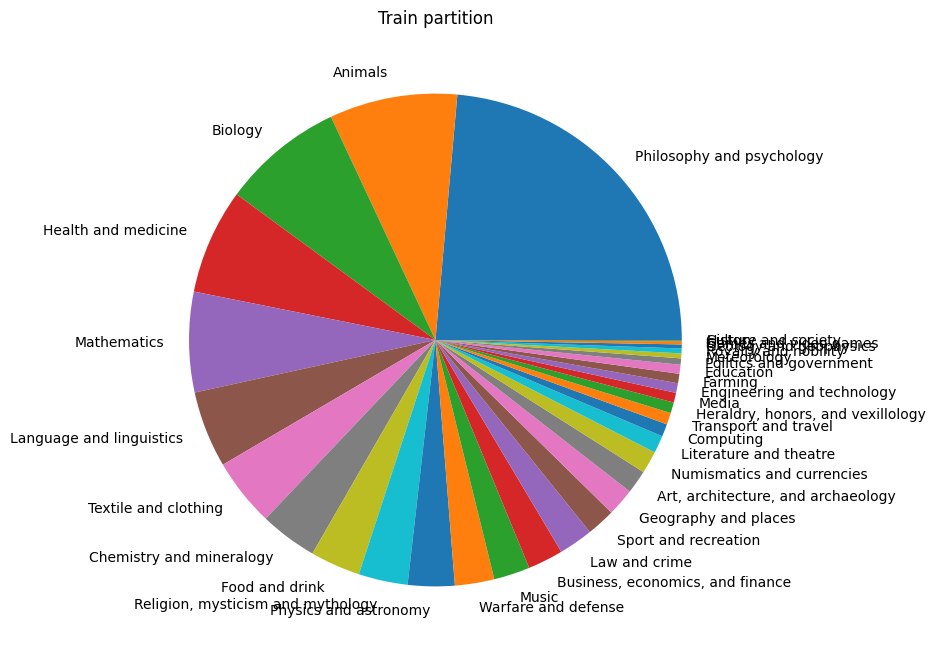

In [6]:
df_train.Domain.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

<Axes: title={'center': 'Test partition'}>

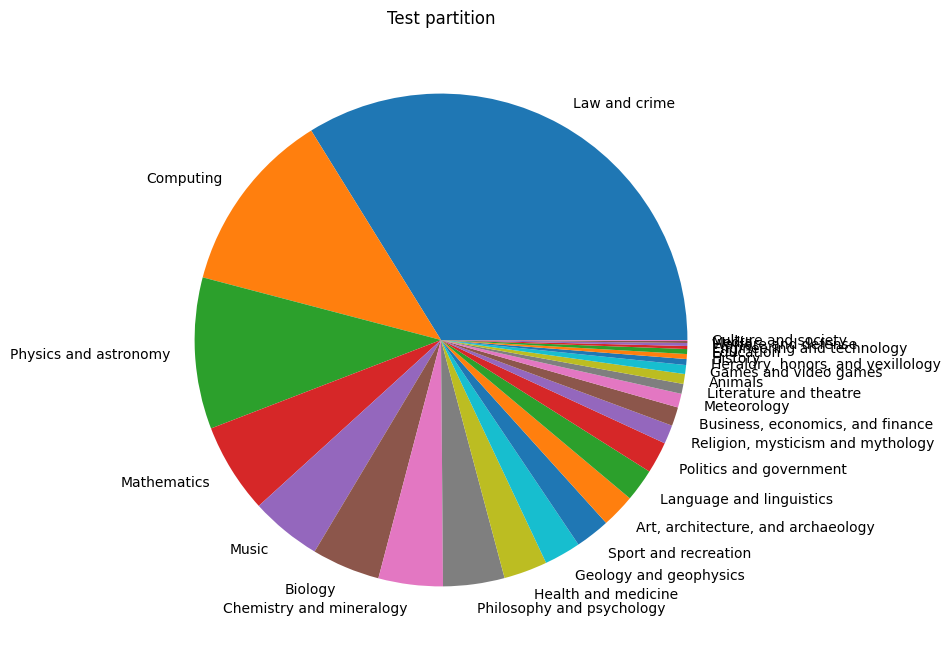

In [7]:
df_test.Domain.value_counts().plot(kind='pie', figsize=(8,8), title="Test partition", ylabel='')

Ahora tenemos que asignar un número entero a cada Dominio para conseguir una relación biyectiva de la columna nueva labels con Dominio.

In [8]:
label2id = {}

def encode_domain(x):
    if x not in label2id.keys():
        label2id[x]=len(label2id)
    return label2id[x]

df_train['labels'] = df_train['Domain'].apply(lambda x: encode_domain(x))
assert df_train['labels'].max() == 33, "The maximum encoded category should be 33" #Hay 34 clases en total
df_train = df_train.drop(columns='Domain')
df_train.head()

,text,labels
0,the quality of being beneficial and generally ...,0
1,insure again by transferring to another insura...,1
2,foolish gibberish,2
3,the property of being a relatively small amoun...,3
4,an arrangement of a piece of music for perform...,4


In [9]:
df_test['labels'] = df_test['Domain'].apply(lambda x: encode_domain(x))
assert df_test['labels'].max() == 33, "The maximum encoded category should be 33" #Hay 34 clases en total
df_test = df_test.drop(columns='Domain')
df_test.head()

,text,labels
0,(physics) statistical law obeyed by a system o...,14
1,(physics) the process in which incident radiat...,14
2,(physics) the exponential return of a system t...,14
3,(physics) a coefficient that expresses how muc...,14
4,(physics) the point of minimum displacement in...,14


In [10]:
id2label = {index: label for label, index in label2id.items()}
print(id2label)

{0: 'Philosophy and psychology', 1: 'Business, economics, and finance', 2: 'Language and linguistics', 3: 'Mathematics', 4: 'Music', 5: 'Animals', 6: 'Warfare and defense', 7: 'Literature and theatre', 8: 'Numismatics and currencies', 9: 'Religion, mysticism and mythology', 10: 'Biology', 11: 'Media', 12: 'Geography and places', 13: 'Education', 14: 'Physics and astronomy', 15: 'Health and medicine', 16: 'Heraldry, honors, and vexillology', 17: 'Engineering and technology', 18: 'Chemistry and mineralogy', 19: 'Law and crime', 20: 'Computing', 21: 'Art, architecture, and archaeology', 22: 'Food and drink', 23: 'Textile and clothing', 24: 'Sport and recreation', 25: 'Transport and travel', 26: 'Geology and geophysics', 27: 'Farming', 28: 'Politics and government', 29: 'Meteorology', 30: 'Royalty and nobility', 31: 'Culture and society', 32: 'Games and video games', 33: 'History'}


Aquí podemos ver la distribución de la longitud de las glosas **sin tokenizar**

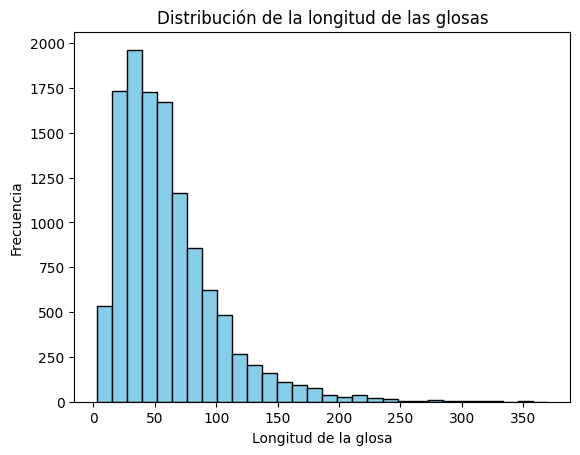

In [11]:
longitudes = df_train['text'].apply(len)

# Crear el histograma usando el método plot de pandas
longitudes.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# Configurar el título y etiquetas de los ejes
plt.title('Distribución de la longitud de las glosas')
plt.xlabel('Longitud de la glosa')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

Vamos a crear la partición de validación y ya podemos crear los tres Datasets

In [12]:
train_size = 0.85
train=df_train.sample(frac=train_size,random_state=200).reset_index(drop=True)
valid=df_train.drop(train.index).reset_index(drop=True)
train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(valid)
test_dataset = Dataset.from_pandas(df_test)

## Búsqueda de hiperparametros
### DistilBERT

In [13]:
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Tokenizamos las glosas con el respectivo tokenizador y creamos los dataloaders

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

In [15]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/10072 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Cargamos el modelo que nos interesa. Tener en cuenta que `AutoModelForSequenceClassification` cargará la arquitectura y checkpoint que seleccionamos con model_ckpt y le añadirá una capa feed-forward pre-classifier de 768x768 y otra classifier 768x34, junto con un dropout de 0.2. Los pesos de estas capas extra se inicializan aleatoriamente, por lo que la tarea del fine-tunning puede verse afectada. Es por esto que se ha añadido una semilla al principio del notebook, para asegurar reproducibilidad.

En esta celda se hacen los cambios para experimentar con las combinaciones de los hiperparámetros que he considerado más importantes.

In [ ]:
num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Training loop (PyTorch)

In [ ]:

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        if (batch_num + 1) % 50 == 0:
            model.eval()  
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()
                    logits = val_outputs.logits
                    predictions = torch.argmax(logits, dim=-1)
                    metric.add_batch(predictions=predictions, references=val_batch["labels"])

                val_acc = metric.compute()['accuracy']


            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 50)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 50:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
            train_loss=0.0



  0%|          | 0/1890 [00:00<?, ?it/s]

Epoch 1, Iteration 50, Training Loss: 0.6644, Validation Loss: 1.9459, Validation Accuracy: 0.6089
Epoch 1, Iteration 100, Training Loss: 0.3834, Validation Loss: 1.1575, Validation Accuracy: 0.7580
Epoch 1, Iteration 150, Training Loss: 0.2491, Validation Loss: 0.8478, Validation Accuracy: 0.8120
Epoch 1, Iteration 200, Training Loss: 0.2133, Validation Loss: 0.6764, Validation Accuracy: 0.8514
Epoch 1, Iteration 250, Training Loss: 0.1822, Validation Loss: 0.5822, Validation Accuracy: 0.8633
Epoch 1, Iteration 300, Training Loss: 0.1715, Validation Loss: 0.5156, Validation Accuracy: 0.8779
Epoch 2, Iteration 50, Training Loss: 0.1180, Validation Loss: 0.4292, Validation Accuracy: 0.8959
Epoch 2, Iteration 100, Training Loss: 0.0933, Validation Loss: 0.3751, Validation Accuracy: 0.9077
Epoch 2, Iteration 150, Training Loss: 0.0959, Validation Loss: 0.3721, Validation Accuracy: 0.9105
Epoch 2, Iteration 200, Training Loss: 0.0926, Validation Loss: 0.3130, Validation Accuracy: 0.9291
Ep

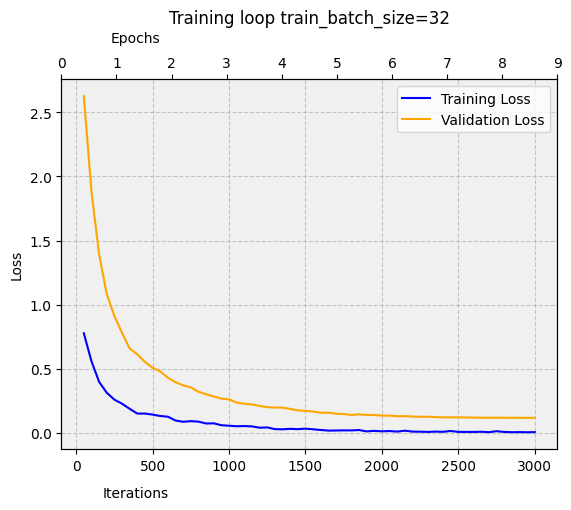

In [ ]:
iterations_x = np.arange(1, len(train_losses) + 1) * 50  # Crea un array de valores para cada 200 iteraciones

epochs_x = np.arange(0, num_epochs)  # Crea un array de valores para las épocas

fig, ax1 = plt.subplots()

ax1.plot(iterations_x, train_losses, label='Training Loss', color='blue')
ax1.plot(iterations_x, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper right')
ax1.xaxis.set_label_coords(0.15, -0.1)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_facecolor('#f0f0f0')

# Crear un segundo eje x para las épocas
ax2 = ax1.twiny()
ax2.set_xticks(epochs_x)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss', color='black') 
ax2.xaxis.set_label_coords(0.15, 1.1)
title = ax1.set_title("Training loop train_batch_size=32")
title.set_y(2)


plt.show()

Métricas de evaluación para test

In [16]:

def compute_metrics(preds, labels):

    # Obtain predicted class labels by finding the column index with the maximum probability

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary

    return {
    'Accuracy': acc,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
    }


In [ ]:
model = torch.load("./Pretrained/distilbertEpoch6Tasa5e-5WarmCos")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.8792207792207792, 'F1': 0.8764749040816545, 'Precision': 0.8909582435735336, 'Recall': 0.8792207792207792}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Guardamos el modelo que acabamos de entrenar

In [ ]:
torch.save(model, "./Pretrained/distilbertEpoch6Tasa8e-5WarmCos")

#### TrainFull
Aquí se volverá a entrenar el modelo con los hiperparámetros seleccionados, pero esta vez en el conjunto completo train+dev

In [ ]:
trainfull_dataset = Dataset.from_pandas(df_train)
tokenizedfull_train = trainfull_dataset.map(preprocess_function, batched=True)
tokenizedfull_train = tokenizedfull_train.remove_columns(["text"])

tokenizedfull_train.set_format("torch")
trainfull_dataloader = DataLoader(tokenizedfull_train, batch_size=32, shuffle=True, collate_fn=data_collator)

Map:   0%|          | 0/11849 [00:00<?, ? examples/s]

In [ ]:
num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 6
num_training_steps = num_epochs * len(trainfull_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
progress_bar = tqdm(range(num_training_steps))
train_loss=0.0
model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(trainfull_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()




  0%|          | 0/1484 [00:00<?, ?it/s]

0.017824230194091798
2.0305729013681413
0.6258384090662003
0.4471934324130416
0.33715564765036105
0.21126779564656317
0.18925811927765607
0.14559029729105533


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.8642857142857143, 'F1': 0.8607892204010892, 'Precision': 0.8788055107608939, 'Recall': 0.8642857142857143}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Probando otros modelos
#### Bert-Base

In [35]:
model_ckpt='bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


Map:   0%|          | 0/10072 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [ ]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)

model.to(device)

    
    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        if (batch_num + 1) % 50 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()
                    logits = val_outputs.logits
                    predictions = torch.argmax(logits, dim=-1)
                    metric.add_batch(predictions=predictions, references=val_batch["labels"])

                val_acc = metric.compute()['accuracy']


            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 50)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 50:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
            train_loss=0.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:

model = torch.load("./Pretrained/bertEpoch4Tasa5e-5CosineWarm100")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)
print(metrics)


{'Accuracy': 0.8525974025974026, 'F1': 0.8555950315333186, 'Precision': 0.8800199189790212, 'Recall': 0.8525974025974026}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.save(model, "./Pretrained/bertEpoch4Tasa3e-5LinealWarm100")

##### TrainFull

In [ ]:
model_ckpt = "bert-base-uncased"
trainfull_dataset = Dataset.from_pandas(df_train)
tokenizedfull_train = trainfull_dataset.map(preprocess_function, batched=True)
tokenizedfull_train = tokenizedfull_train.remove_columns(["text"])

tokenizedfull_train.set_format("torch")
trainfull_dataloader = DataLoader(tokenizedfull_train, batch_size=32, shuffle=True, collate_fn=data_collator)

Map:   0%|          | 0/11849 [00:00<?, ? examples/s]

In [ ]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 4
num_training_steps = num_epochs * len(trainfull_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
model.to(device)
progress_bar = tqdm(range(num_training_steps))
train_loss=0.0
model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(trainfull_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()
        if (batch_num+1)%200==0:
            print(train_loss/200)
            train_loss=0.0



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1484 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


0.01781702518463135
1.9852690252661704
0.693440227508545
0.47142112378031015
0.35483070092275737
0.23915977058932186
0.16609195677563549
0.14207945662550628


In [ ]:

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

NameError: name 'compute_metrics' is not defined

#### Roberta

In [38]:
model_ckpt='roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


Map:   0%|          | 0/10072 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [ ]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 6 ##Hyperparameter
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)

model.to(device)

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    if epoch==4:
        torch.save(model, "robertaEpoch4Tasa5e-5CosineWarm")
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()
        if (batch_num + 1) % 50 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()
                    logits = val_outputs.logits
                    predictions = torch.argmax(logits, dim=-1)
                    metric.add_batch(predictions=predictions, references=val_batch["labels"])

                val_acc = metric.compute()['accuracy']


            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 50)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 50:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
            train_loss=0.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1890 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Iteration 50, Training Loss: 3.2331, Validation Loss: 2.6914, Validation Accuracy: 0.2645
Epoch 1, Iteration 100, Training Loss: 1.9133, Validation Loss: 1.2353, Validation Accuracy: 0.7349
Epoch 1, Iteration 150, Training Loss: 1.0843, Validation Loss: 0.8515, Validation Accuracy: 0.8109
Epoch 1, Iteration 200, Training Loss: 0.8959, Validation Loss: 0.7820, Validation Accuracy: 0.8177
Epoch 1, Iteration 250, Training Loss: 0.8245, Validation Loss: 0.6621, Validation Accuracy: 0.8374
Epoch 1, Iteration 300, Training Loss: 0.7084, Validation Loss: 0.5507, Validation Accuracy: 0.8672
Epoch 2, Iteration 50, Training Loss: 0.5877, Validation Loss: 0.4721, Validation Accuracy: 0.8869
Epoch 2, Iteration 100, Training Loss: 0.4483, Validation Loss: 0.4534, Validation Accuracy: 0.8807
Epoch 2, Iteration 150, Training Loss: 0.4526, Validation Loss: 0.4044, Validation Accuracy: 0.9010
Epoch 2, Iteration 200, Training Loss: 0.4509, Validation Loss: 0.3562, Validation Accuracy: 0.9128
Ep

In [ ]:


model = torch.load("./Pretrained/robertaEpoch6Tasa5e-5CosineWarm")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)
print(metrics)


{'Accuracy': 0.8467532467532467, 'F1': 0.8482724013352022, 'Precision': 0.8690815985370052, 'Recall': 0.8467532467532467}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.save(model, "./Pretrained/robertaEpoch6Tasa5e-5CosineWarm")

##### TrainFull

In [ ]:
model_ckpt = "roberta-base"
trainfull_dataset = Dataset.from_pandas(df_train)
tokenizedfull_train = trainfull_dataset.map(preprocess_function, batched=True)
tokenizedfull_train = tokenizedfull_train.remove_columns(["text"])

tokenizedfull_train.set_format("torch")
trainfull_dataloader = DataLoader(tokenizedfull_train, batch_size=32, shuffle=True, collate_fn=data_collator)


Map:   0%|          | 0/11849 [00:00<?, ? examples/s]

In [ ]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 6
num_training_steps = num_epochs * len(trainfull_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
model.to(device)
progress_bar = tqdm(range(num_training_steps))
train_loss=0.0
model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(trainfull_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2226 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


2.241199581623077
1.5040226589888335
0.9416740147769451
0.6508070577681064
0.5078435648977756
0.4019292965345085


In [ ]:


model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.8597402597402597, 'F1': 0.8593325220089794, 'Precision': 0.8766411737983689, 'Recall': 0.8597402597402597}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Few-Shot

Para hacer el few-shot vamos a crear 3 datasets con 5, 10 y 20 instancias por clase, respectivamente. Hay clases que de por sí tienen menos de 5 instancias `Culture and society`, esas se quedarán así. 

In [ ]:
df_5 = df_train.groupby('labels').head(5)
df_5.labels.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

,text,labels
0,the quality of being beneficial and generally ...,0
1,insure again by transferring to another insura...,1
2,foolish gibberish,2
3,the property of being a relatively small amoun...,3
4,an arrangement of a piece of music for perform...,4


<Axes: title={'center': 'Train partition'}>

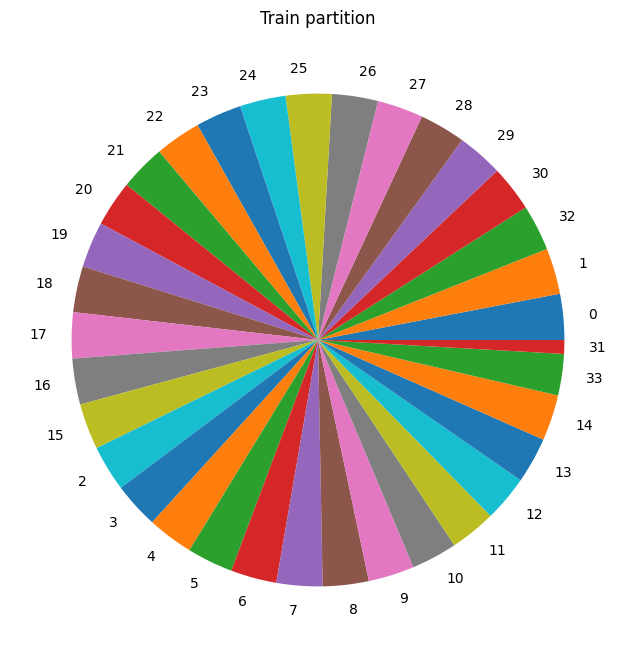

In [ ]:
df_10 = df_train.groupby('labels').head(10)
df_10.labels.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

<Axes: title={'center': 'Train partition'}>

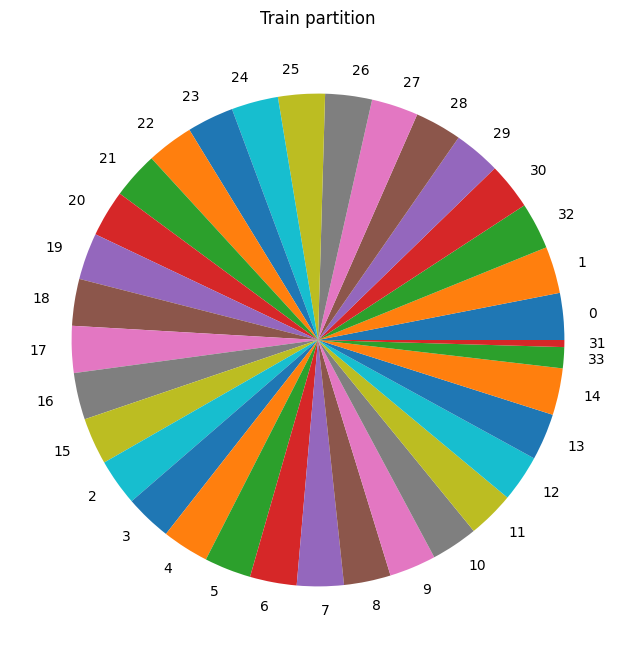

In [ ]:
df_20 = df_train.groupby('labels').head(20)
df_20.labels.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

#### DistilBERT 5

In [ ]:
train_dataset = Dataset.from_pandas(df_5)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset)

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 168
})


In [ ]:
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_train = tokenized_train.remove_columns(["__index_level_0__"])

tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=1, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [ ]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)
metric = load_metric("accuracy")

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

model.train()

for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()


    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_dataloader):.4f}")
    train_loss=0.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3360 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Training Loss: 3.5194, Validation Loss: 3.2755, Validation Accuracy: 0.2110
Epoch 2, Training Loss: 2.7450, Validation Loss: 2.4323, Validation Accuracy: 0.5831
Epoch 3, Training Loss: 1.6279, Validation Loss: 1.7334, Validation Accuracy: 0.6636
Epoch 4, Training Loss: 0.8729, Validation Loss: 1.2429, Validation Accuracy: 0.7818
Epoch 5, Training Loss: 0.3908, Validation Loss: 1.1506, Validation Accuracy: 0.7552
Epoch 6, Training Loss: 0.1915, Validation Loss: 1.0428, Validation Accuracy: 0.7351
Epoch 7, Training Loss: 0.1141, Validation Loss: 0.9479, Validation Accuracy: 0.7714
Epoch 8, Training Loss: 0.0843, Validation Loss: 0.9316, Validation Accuracy: 0.7656
Epoch 9, Training Loss: 0.0635, Validation Loss: 0.9143, Validation Accuracy: 0.7708
Epoch 10, Training Loss: 0.0523, Validation Loss: 0.9088, Validation Accuracy: 0.7695
Epoch 11, Training Loss: 0.0438, Validation Loss: 0.9049, Validation Accuracy: 0.7688
Epoch 12, Training Loss: 0.0368, Validation Loss: 0.9002, Valid

In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.7766233766233767, 'F1': 0.7969333439112938, 'Precision': 0.8479023738777426, 'Recall': 0.7766233766233767}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DistilBERT 10

In [ ]:
train_dataset = Dataset.from_pandas(df_10)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset)
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_train = tokenized_train.remove_columns(["__index_level_0__"])

tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=4, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)
metric = load_metric("accuracy")

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        
    
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_dataloader):.4f}")
    train_loss=0.0




model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 332
})


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1660 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Training Loss: 3.4892, Validation Loss: 3.1452, Validation Accuracy: 0.1617
Epoch 2, Training Loss: 2.7586, Validation Loss: 2.3315, Validation Accuracy: 0.6727
Epoch 3, Training Loss: 1.6497, Validation Loss: 1.6064, Validation Accuracy: 0.7162
Epoch 4, Training Loss: 0.8195, Validation Loss: 1.2399, Validation Accuracy: 0.7188
Epoch 5, Training Loss: 0.3945, Validation Loss: 1.0577, Validation Accuracy: 0.7513
Epoch 6, Training Loss: 0.2095, Validation Loss: 1.0064, Validation Accuracy: 0.7494
Epoch 7, Training Loss: 0.1288, Validation Loss: 0.9850, Validation Accuracy: 0.7513
Epoch 8, Training Loss: 0.0923, Validation Loss: 0.9775, Validation Accuracy: 0.7519
Epoch 9, Training Loss: 0.0718, Validation Loss: 0.9681, Validation Accuracy: 0.7545
Epoch 10, Training Loss: 0.0589, Validation Loss: 0.9772, Validation Accuracy: 0.7552
Epoch 11, Training Loss: 0.0494, Validation Loss: 0.9704, Validation Accuracy: 0.7571
Epoch 12, Training Loss: 0.0416, Validation Loss: 0.9770, Valid

/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DistilBERT 20

In [ ]:
train_dataset = Dataset.from_pandas(df_20)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset)
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_train = tokenized_train.remove_columns(["__index_level_0__"])

tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=4, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)
metric = load_metric("accuracy")

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_dataloader):.4f}")
    train_loss=0.0


model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 652
})


Map:   0%|          | 0/652 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3260 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Training Loss: 3.0090, Validation Loss: 2.0683, Validation Accuracy: 0.8045
Epoch 2, Training Loss: 1.4752, Validation Loss: 1.1932, Validation Accuracy: 0.8253
Epoch 3, Training Loss: 0.6391, Validation Loss: 0.8919, Validation Accuracy: 0.8545
Epoch 4, Training Loss: 0.2876, Validation Loss: 0.8298, Validation Accuracy: 0.8494
Epoch 5, Training Loss: 0.1417, Validation Loss: 1.0369, Validation Accuracy: 0.7831
Epoch 6, Training Loss: 0.0740, Validation Loss: 0.9926, Validation Accuracy: 0.7948
Epoch 7, Training Loss: 0.0459, Validation Loss: 0.8845, Validation Accuracy: 0.8234
Epoch 8, Training Loss: 0.0295, Validation Loss: 0.9114, Validation Accuracy: 0.8214
Epoch 9, Training Loss: 0.0233, Validation Loss: 0.9269, Validation Accuracy: 0.8234
Epoch 10, Training Loss: 0.0188, Validation Loss: 0.9321, Validation Accuracy: 0.8253
Epoch 11, Training Loss: 0.0161, Validation Loss: 0.9399, Validation Accuracy: 0.8234
Epoch 12, Training Loss: 0.0140, Validation Loss: 0.9500, Valid

/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Resultados y Analisis

**Nota**: Para cada modelo hay que tokenizar los dataloaders con su respectivo tokenizador

/tmp/ipykernel_6797/1205360865.py:24: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


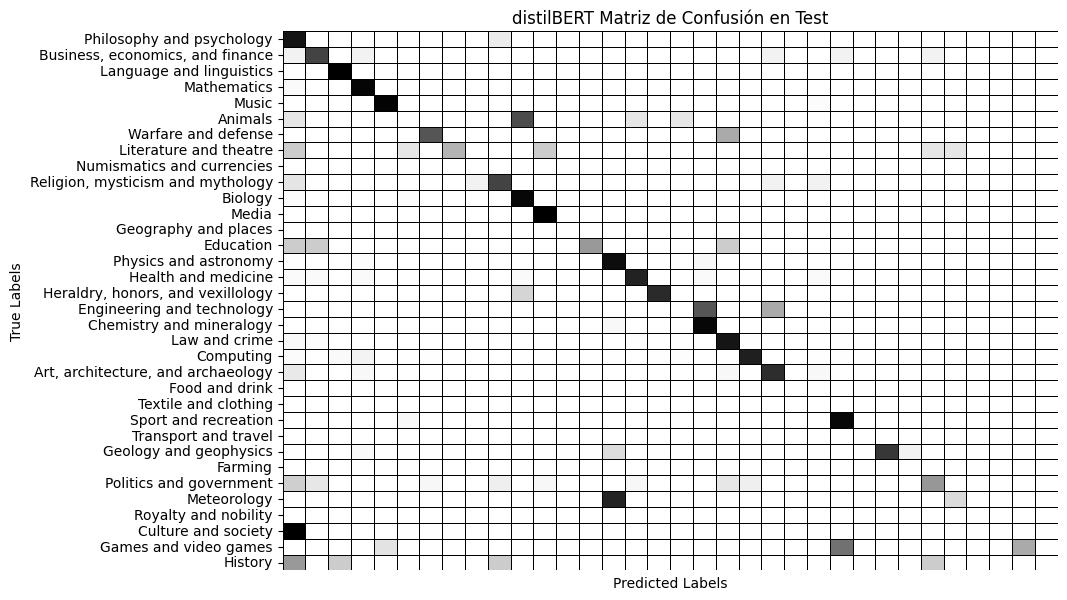

In [31]:
model = torch.load("./Pretrained/distilbertEpoch6Tasa5e-5WarmCos")
# model = torch.load("./Pretrained/distilbertEpoch10Tasa2e-5")

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

all_possible_labels = list(label2id.values())

conf_matrix = confusion_matrix(all_labels, all_preds, labels=all_possible_labels)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

conf_matrix_df = pd.DataFrame(conf_matrix_normalized, 
                              index=[id2label[id] for id in all_possible_labels], 
                              columns=[id2label[id] for id in all_possible_labels])

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_df, annot=False, cmap='binary', linecolor='black', linewidths=0.5, cbar=False, xticklabels=False)
plt.title('distilBERT Matriz de Confusión en Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

/tmp/ipykernel_6797/386154164.py:23: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


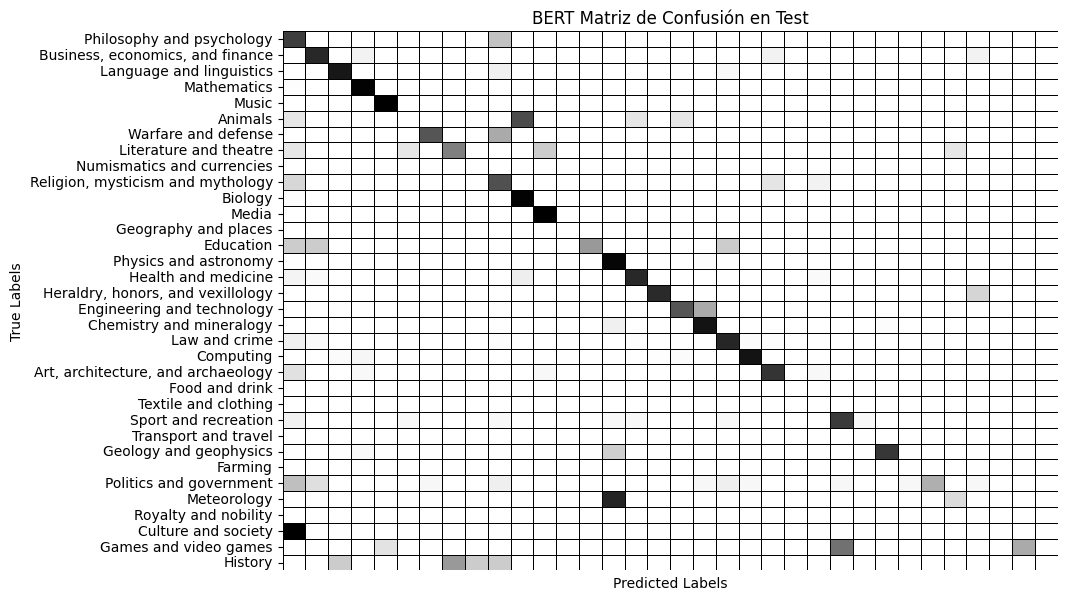

In [37]:
model = torch.load("./Pretrained/bertEpoch4Tasa5e-5CosineWarm100")

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

all_possible_labels = list(label2id.values())

conf_matrix = confusion_matrix(all_labels, all_preds, labels=all_possible_labels)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

conf_matrix_df = pd.DataFrame(conf_matrix_normalized, 
                              index=[id2label[id] for id in all_possible_labels], 
                              columns=[id2label[id] for id in all_possible_labels])

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_df, annot=False, cmap='binary', linecolor='black', linewidths=0.5, cbar=False, xticklabels=False)
plt.title('BERT Matriz de Confusión en Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_6797/3293076636.py:23: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


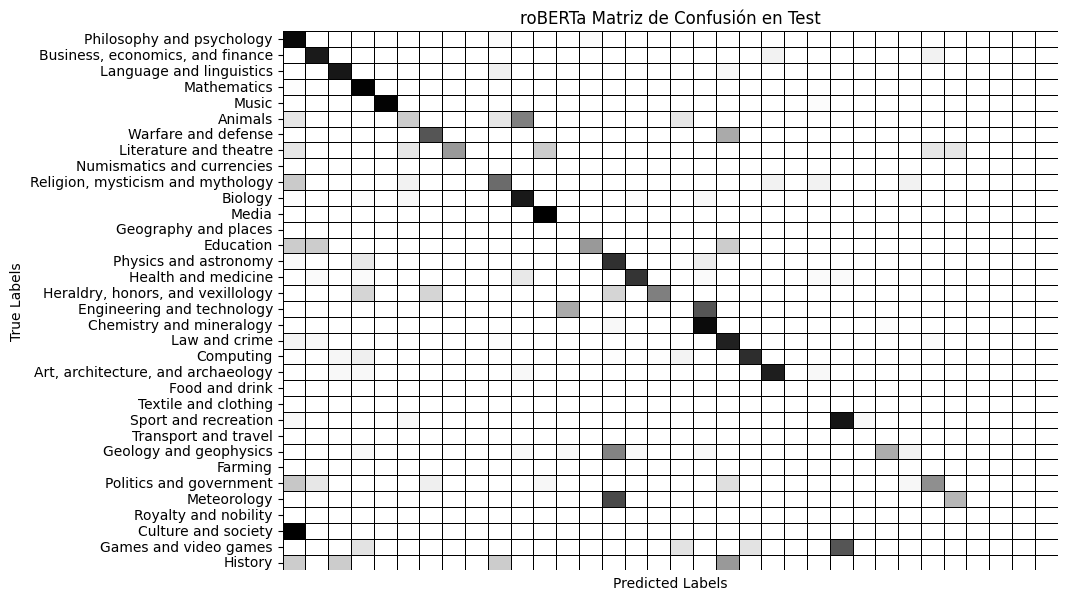

In [39]:
model = torch.load("./Pretrained/robertaEpoch6Tasa2e-5CosineWarm")

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

all_possible_labels = list(label2id.values())

conf_matrix = confusion_matrix(all_labels, all_preds, labels=all_possible_labels)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

conf_matrix_df = pd.DataFrame(conf_matrix_normalized, 
                              index=[id2label[id] for id in all_possible_labels], 
                              columns=[id2label[id] for id in all_possible_labels])

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_df, annot=False, cmap='binary', linecolor='black', linewidths=0.5, cbar=False, xticklabels=False)
plt.title('roBERTa Matriz de Confusión en Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()